# Back Test Analysis

This notebook implements a comprehensive pairs trading strategy for BTC-USDT and ETH-USDT cryptocurrency pairs. It incorporates robust statistical analysis, dynamic hedge ratio calculation, and complete backtesting framework.

## 1. Imports and Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.api as sm
import os

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')

# Create docs directory for saving plots
os.makedirs('docs', exist_ok=True)

## 2. Helper Functions

In [4]:
# Function to run linear regression
def lin_reg(X, Y):
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    params = model.params
    return params

## 3. Load and Prepare Data

In [5]:
print("Loading BTC-USDT and ETH-USDT data...")

# Load the data
btcusdt = pd.read_csv('../data/btcusdt_1m_raw.csv')
ethusdt = pd.read_csv('../data/ethusdt_1m_raw.csv')

# Basic data exploration
print("BTCUSDT data shape:", btcusdt.shape)
print("ETHUSDT data shape:", ethusdt.shape)

Loading BTC-USDT and ETH-USDT data...
BTCUSDT data shape: (131101, 13)
ETHUSDT data shape: (131101, 13)


In [6]:
# Convert timestamp to datetime if not already done
btcusdt['datetime'] = pd.to_datetime(btcusdt['datetime'])
ethusdt['datetime'] = pd.to_datetime(ethusdt['datetime'])

# Set datetime as index
btcusdt.set_index('datetime', inplace=True)
ethusdt.set_index('datetime', inplace=True)

# Check data info
print("BTCUSDT date range:", btcusdt.index.min(), "to", btcusdt.index.max())
print("ETHUSDT date range:", ethusdt.index.min(), "to", ethusdt.index.max())

BTCUSDT date range: 2023-10-01 07:00:00 to 2023-12-31 08:00:00
ETHUSDT date range: 2023-10-01 07:00:00 to 2023-12-31 08:00:00


In [7]:
# Resample to hourly data to reduce noise
btcusdt_hourly = btcusdt['close'].resample('1H').last()
ethusdt_hourly = ethusdt['close'].resample('1H').last()

# Ensure we're working with common timestamps
common_index = btcusdt_hourly.index.intersection(ethusdt_hourly.index)
btc_aligned = btcusdt_hourly.loc[common_index]
eth_aligned = ethusdt_hourly.loc[common_index]

print(f"Length of aligned hourly data: {len(btc_aligned)}")

Length of aligned hourly data: 2186


/var/folders/68/wxyhd8w91wd6kpnxj47fx_y40000gn/T/ipykernel_70085/549408514.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  btcusdt_hourly = btcusdt['close'].resample('1H').last()
/var/folders/68/wxyhd8w91wd6kpnxj47fx_y40000gn/T/ipykernel_70085/549408514.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ethusdt_hourly = ethusdt['close'].resample('1H').last()


## 4. Train-Test Split

We'll split our data into training (80%) and testing (20%) periods to develop our model on historical data and evaluate it on out-of-sample data.

In [8]:
# Split data into training and testing periods (80% train, 20% test)
train_size = int(len(btc_aligned) * 0.8)
btc_train = btc_aligned[:train_size]
eth_train = eth_aligned[:train_size]
btc_test = btc_aligned[train_size:]
eth_test = eth_aligned[train_size:]

print(f"Train period: {btc_train.index.min()} to {btc_train.index.max()}")
print(f"Test period: {btc_test.index.min()} to {btc_test.index.max()}")

Train period: 2023-10-01 07:00:00 to 2023-12-13 02:00:00
Test period: 2023-12-13 03:00:00 to 2023-12-31 08:00:00


In [9]:
# Calculate basic statistics for training data
btc_stats = btc_train.describe()
eth_stats = eth_train.describe()

stats_df = pd.DataFrame({
    'BTC-USDT': btc_stats,
    'ETH-USDT': eth_stats
})

print("\nTraining Data Statistics:")
print(stats_df)


Training Data Statistics:
           BTC-USDT     ETH-USDT
count   1748.000000  1748.000000
mean   34506.828753  1888.392328
std     5043.062333   235.523960
min    26633.740000  1527.000000
25%    28605.290000  1645.582500
50%    35153.760000  1886.265000
75%    37422.832500  2060.762500
max    44516.450000  2384.560000


## 5. Pair Selection Analysis

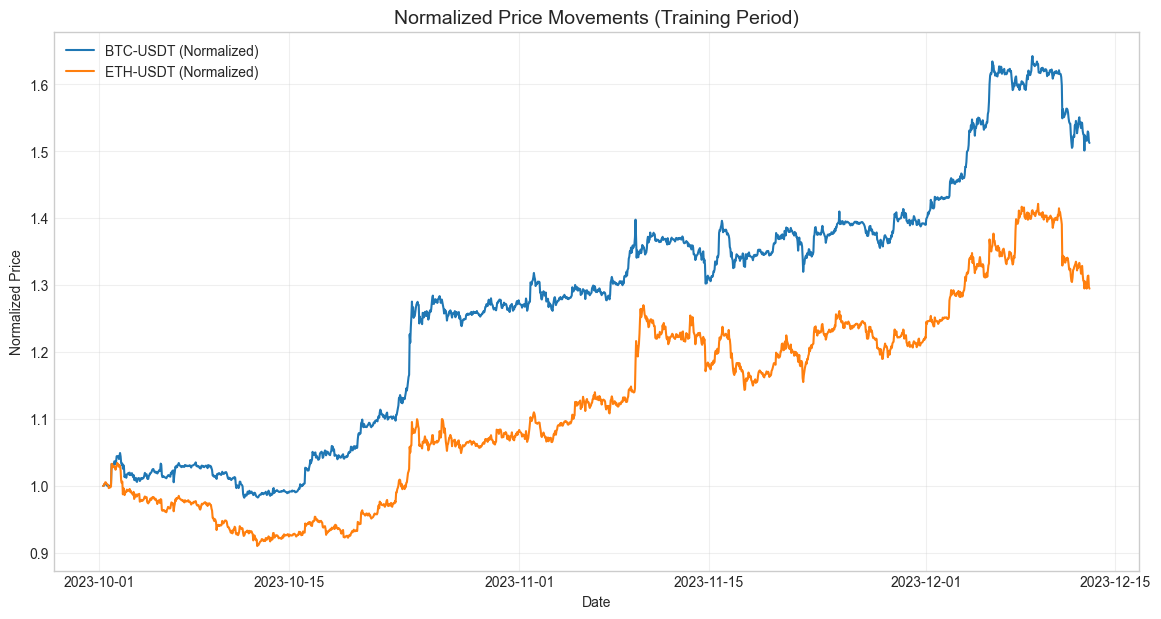

In [10]:
# Normalize price series for visualization
btc_norm = btc_train / btc_train.iloc[0]
eth_norm = eth_train / eth_train.iloc[0]

# Visualize normalized price movements
plt.figure(figsize=(14, 7))
plt.plot(btc_norm.index, btc_norm, label='BTC-USDT (Normalized)')
plt.plot(eth_norm.index, eth_norm, label='ETH-USDT (Normalized)')
plt.title('Normalized Price Movements (Training Period)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('docs/normalized_prices.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Calculate Sum of Squared Differences (SSD)
ssd = ((btc_norm - eth_norm) ** 2).sum()
print(f"\nSum of Squared Differences (SSD): {ssd:.4f}")

# Calculate price correlation
price_correlation = btc_train.corr(eth_train)
print(f"Price correlation between BTC-USDT and ETH-USDT: {price_correlation:.4f}")


Sum of Squared Differences (SSD): 44.0079
Price correlation between BTC-USDT and ETH-USDT: 0.9730


In [12]:
# Test for cointegration
score, pvalue, _ = coint(btc_train, eth_train)
print(f"Cointegration p-value: {pvalue:.4f}")
print(f"Pairs are {'cointegrated' if pvalue < 0.05 else 'not cointegrated'} at 5% significance level")

Cointegration p-value: 0.0920
Pairs are not cointegrated at 5% significance level


## 6. Spread Modeling 

Calculate the hedge ratio and analyze the spread between BTC-USDT and ETH-USDT.


Hedge Ratio: 0.0454
Intercept: 320.3925


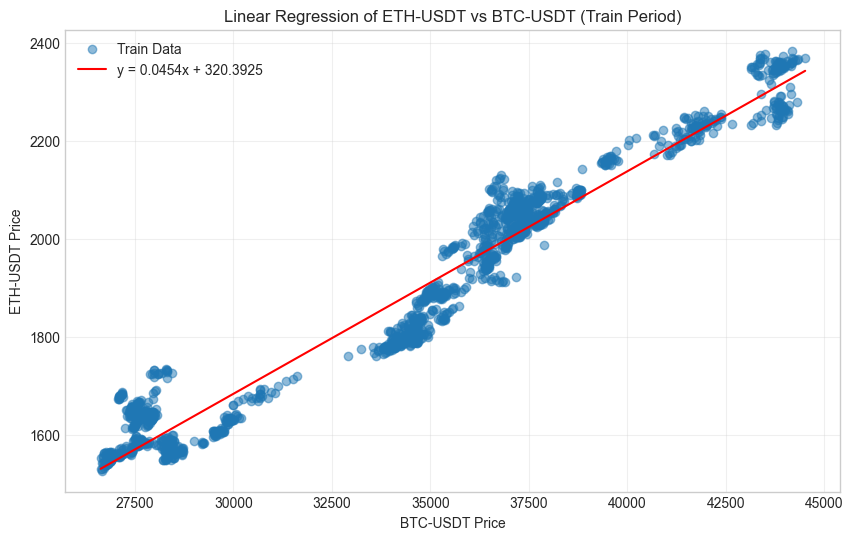

In [13]:
# Perform linear regression to find hedge ratio
intercept, hedge_ratio = lin_reg(btc_train, eth_train)
print(f"\nHedge Ratio: {hedge_ratio:.4f}")
print(f"Intercept: {intercept:.4f}")

# Visualize the relationship with regression line
plt.figure(figsize=(10, 6))
plt.scatter(btc_train, eth_train, alpha=0.5, label='Train Data')
x_line = np.linspace(min(btc_train), max(btc_train), 100)
y_line = hedge_ratio * x_line + intercept
plt.plot(x_line, y_line, 'r', label=f'y = {hedge_ratio:.4f}x + {intercept:.4f}')
plt.title('Linear Regression of ETH-USDT vs BTC-USDT (Train Period)')
plt.xlabel('BTC-USDT Price')
plt.ylabel('ETH-USDT Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('docs/regression.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Calculate spread during training period
train_spread = eth_train - hedge_ratio * btc_train

# Test spread for stationarity
adf_result = adfuller(train_spread.dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"The spread is {'stationary' if adf_result[1] < 0.05 else 'non-stationary'} at 5% significance level")

ADF Statistic: -3.0149
p-value: 0.0335
The spread is stationary at 5% significance level


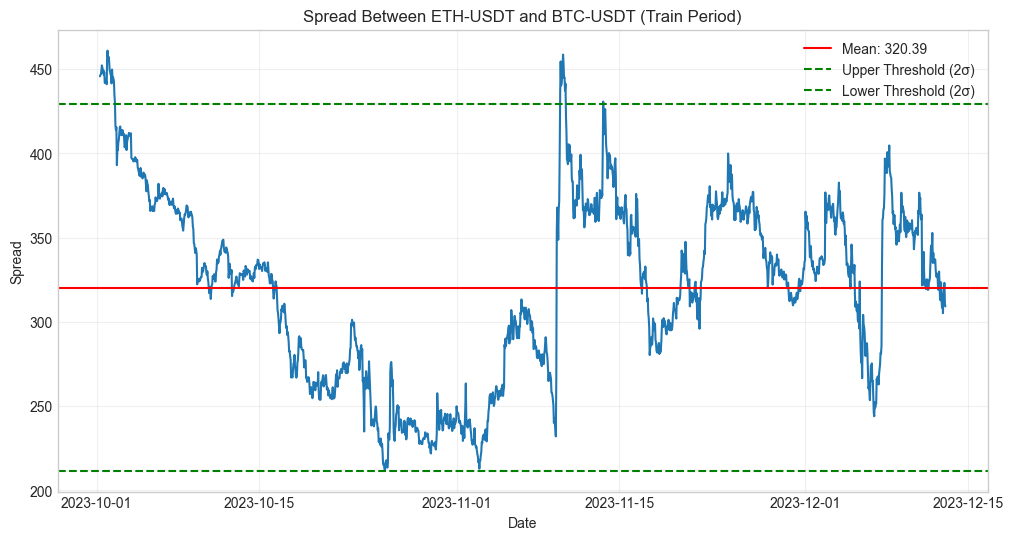

In [15]:
# Visualize the training spread
plt.figure(figsize=(12, 6))
plt.plot(train_spread.index, train_spread)
plt.axhline(y=train_spread.mean(), color='r', linestyle='-', label=f'Mean: {train_spread.mean():.2f}')
plt.axhline(y=train_spread.mean() + 2*train_spread.std(), color='g', linestyle='--', label='Upper Threshold (2σ)')
plt.axhline(y=train_spread.mean() - 2*train_spread.std(), color='g', linestyle='--', label='Lower Threshold (2σ)')
plt.title('Spread Between ETH-USDT and BTC-USDT (Train Period)')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('docs/train_spread.png', dpi=300, bbox_inches='tight')
plt.show()

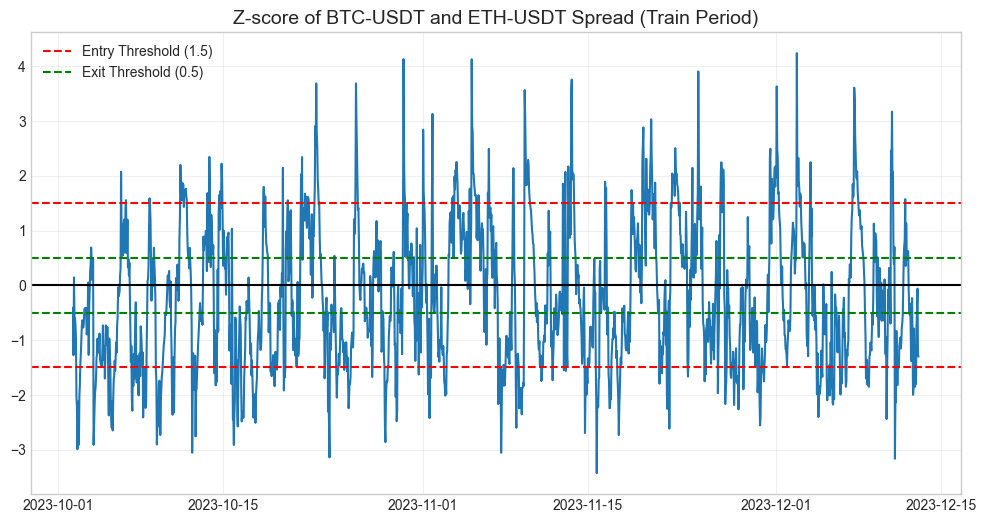

In [16]:
# Calculate z-score with rolling window
train_window = 24  # 24 hours = 1 day rolling window
train_rolling_mean = train_spread.rolling(window=train_window).mean()
train_rolling_std = train_spread.rolling(window=train_window).std()
train_z_score = (train_spread - train_rolling_mean) / train_rolling_std

# Visualize z-score for training period
plt.figure(figsize=(12, 6))
plt.plot(train_z_score.dropna())
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1.5, color='r', linestyle='--', label='Entry Threshold (1.5)')
plt.axhline(y=-1.5, color='r', linestyle='--')
plt.axhline(y=0.5, color='g', linestyle='--', label='Exit Threshold (0.5)')
plt.axhline(y=-0.5, color='g', linestyle='--')
plt.title('Z-score of BTC-USDT and ETH-USDT Spread (Train Period)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('docs/train_zscore.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Rolling Hedge Ratio and Test Period Analysis

Implement a dynamic hedge ratio calculation for the test period.

In [17]:
print("\nCalculating rolling hedge ratios for test period...")
window_size = 24  # 24 hours rolling window
rolling_hedge_ratios = pd.Series(index=btc_test.index, dtype=float)
test_spread_mean = pd.Series(index=btc_test.index, dtype=float)
test_spread_std = pd.Series(index=btc_test.index, dtype=float)

for i in range(window_size, len(btc_test) + 1):
    window_btc = btc_test.iloc[i - window_size:i]
    window_eth = eth_test.iloc[i - window_size:i]
    
    # Compute rolling hedge ratio
    _, rolling_hedge = lin_reg(window_btc, window_eth)
    rolling_hedge_ratios.iloc[i - 1] = rolling_hedge
    
    # Compute window spread statistics
    window_spread = window_eth - rolling_hedge * window_btc
    test_spread_mean.iloc[i - 1] = window_spread.mean()
    test_spread_std.iloc[i - 1] = window_spread.std()


Calculating rolling hedge ratios for test period...


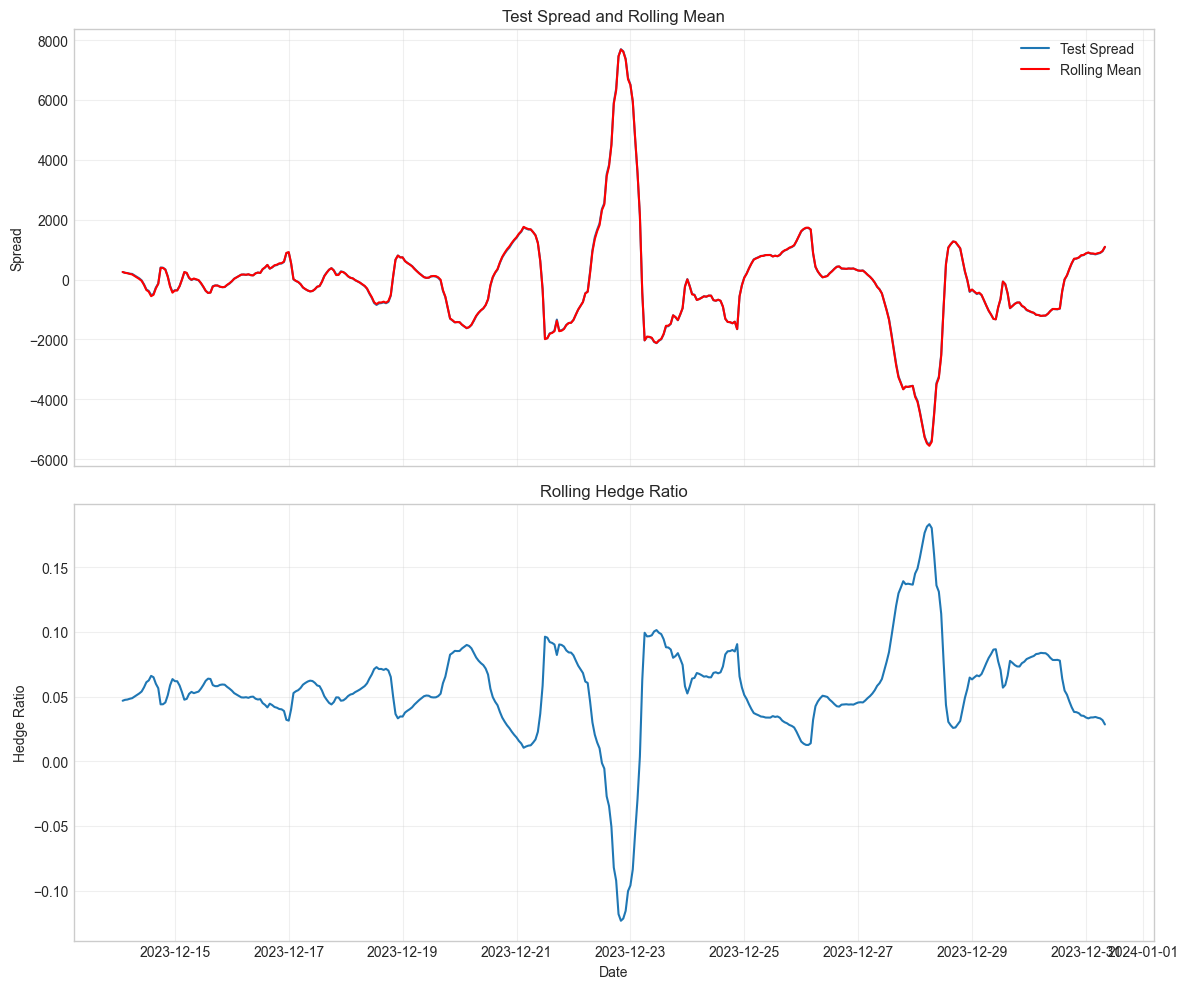

In [18]:
# Calculate spread for test period using rolling hedge ratios
test_spread = eth_test - rolling_hedge_ratios * btc_test

# Visualize test spread and rolling hedge ratio
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot test spread
axes[0].plot(test_spread.index, test_spread, label='Test Spread')
axes[0].plot(test_spread_mean.index, test_spread_mean, label='Rolling Mean', color='red')
axes[0].set_title('Test Spread and Rolling Mean')
axes[0].set_ylabel('Spread')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot rolling hedge ratio
axes[1].plot(rolling_hedge_ratios.index, rolling_hedge_ratios)
axes[1].set_title('Rolling Hedge Ratio')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Hedge Ratio')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('docs/test_spread_and_hedge_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

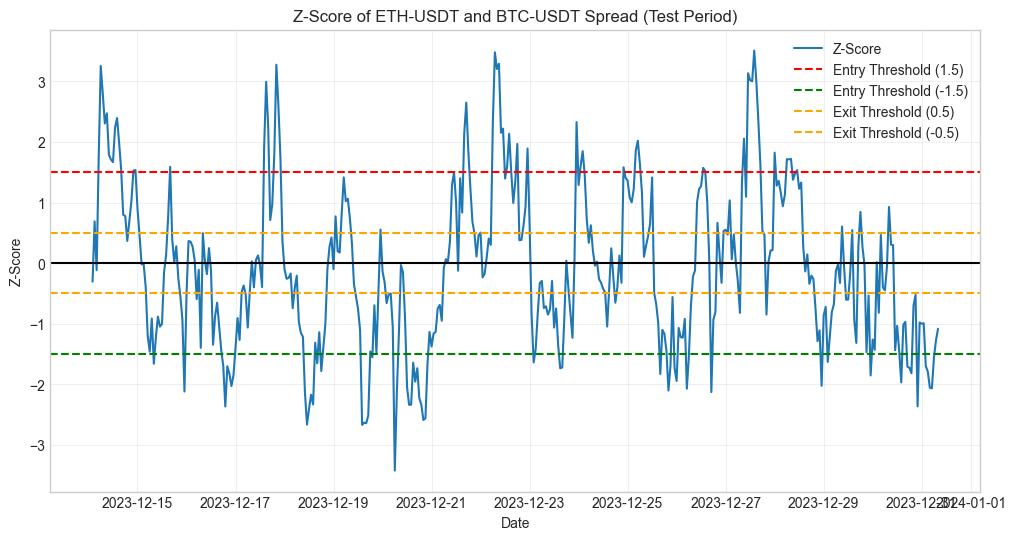

In [19]:
# Calculate z-score (normalized spread)
z_score = (test_spread - test_spread_mean) / test_spread_std

# Visualize normalized spread (z-score)
plt.figure(figsize=(12, 6))
plt.plot(z_score.index, z_score, label='Z-Score')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1.5, color='r', linestyle='--', label='Entry Threshold (1.5)')
plt.axhline(y=-1.5, color='g', linestyle='--', label='Entry Threshold (-1.5)')
plt.axhline(y=0.5, color='orange', linestyle='--', label='Exit Threshold (0.5)')
plt.axhline(y=-0.5, color='orange', linestyle='--', label='Exit Threshold (-0.5)')
plt.title('Z-Score of ETH-USDT and BTC-USDT Spread (Test Period)')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('docs/test_zscore.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Backtesting Framework

Implement a complete backtesting framework with trading rules based on z-score signals.

In [20]:
print("\nImplementing backtesting framework...")

# Create strategy dataframe
strategy = pd.DataFrame(index=z_score.index)
strategy['BTC'] = btc_test
strategy['ETH'] = eth_test
strategy['Z_Score'] = z_score
strategy['Hedge_Ratio'] = rolling_hedge_ratios
strategy['Signal'] = 0
strategy['Position'] = 0

# Drop any NaN values
strategy = strategy.dropna()


Implementing backtesting framework...


In [ ]:
# Implement trading rules
current_position = 0

for i in range(1, len(strategy)):
    # Enter long position (buy spread) when z-score < -1.5
    if strategy['Z_Score'].iloc[i] < -1.5 and current_position == 0:
        strategy['Signal'].iloc[i] = 1
        current_position = 1
    
    # Enter short position (sell spread) when z-score > 1.5
    elif strategy['Z_Score'].iloc[i] > 1.5 and current_position == 0:
        strategy['Signal'].iloc[i] = -1
        current_position = -1
    
    # Exit long position when z-score crosses above 0.5
    elif strategy['Z_Score'].iloc[i] > 0.5 and current_position == 1:
        strategy['Signal'].iloc[i] = -1
        current_position = 0
    
    # Exit short position when z-score crosses below -0.5
    elif strategy['Z_Score'].iloc[i] < -0.5 and current_position == -1:
        strategy['Signal'].iloc[i] = 1
        current_position = 0
    
    # Record current position
    strategy['Position'].iloc[i] = current_position

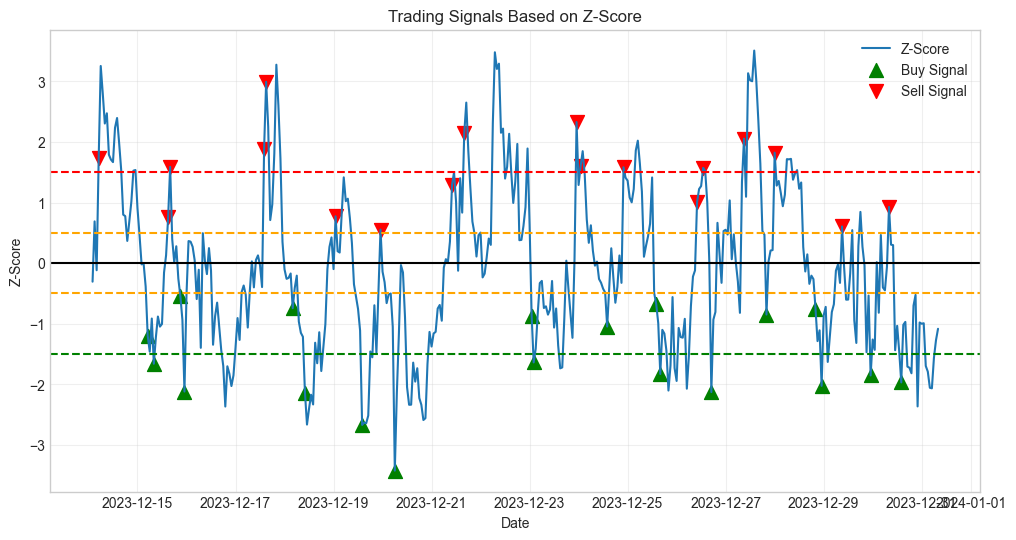

In [22]:
# Plot buy and sell signals
buy_signals = strategy[strategy['Signal'] == 1]
sell_signals = strategy[strategy['Signal'] == -1]

plt.figure(figsize=(12, 6))
plt.plot(strategy.index, strategy['Z_Score'], label='Z-Score')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1.5, color='r', linestyle='--')
plt.axhline(y=-1.5, color='g', linestyle='--')
plt.axhline(y=0.5, color='orange', linestyle='--')
plt.axhline(y=-0.5, color='orange', linestyle='--')
plt.scatter(buy_signals.index, buy_signals['Z_Score'], marker='^', color='green', s=100, label='Buy Signal')
plt.scatter(sell_signals.index, sell_signals['Z_Score'], marker='v', color='red', s=100, label='Sell Signal')
plt.title('Trading Signals Based on Z-Score')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('docs/trading_signals.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Performance Analysis

Calculate returns and performance metrics for the strategy.

In [23]:
# Calculate returns
strategy['BTC_Return'] = np.log(strategy['BTC'] / strategy['BTC'].shift(1))
strategy['ETH_Return'] = np.log(strategy['ETH'] / strategy['ETH'].shift(1))
strategy['Spread_Return'] = strategy['ETH_Return'] - strategy['Hedge_Ratio'].shift(1) * strategy['BTC_Return']
strategy['Strategy_Return'] = strategy['Spread_Return'] * strategy['Position'].shift(1)
strategy['Cum_Return'] = strategy['Strategy_Return'].fillna(0).cumsum().apply(np.exp)

In [24]:
# Calculate trading statistics
total_trades = (strategy['Signal'] != 0).sum()
winning_trades = ((strategy['Signal'] == 1) & (strategy['Strategy_Return'].shift(-1) > 0)).sum() + \
                ((strategy['Signal'] == -1) & (strategy['Strategy_Return'].shift(-1) < 0)).sum()
if total_trades > 0:
    win_rate = winning_trades / total_trades
else:
    win_rate = 0

In [25]:
# Calculate performance metrics
print("\nCalculating performance metrics...")
total_return = strategy['Cum_Return'].iloc[-1] - 1
annual_return = (1 + total_return) ** (365 / (len(strategy) / 24)) - 1  # Annualized hourly data
sharpe_ratio = strategy['Strategy_Return'].mean() / strategy['Strategy_Return'].std() * np.sqrt(365 * 24)  # Annualized
max_drawdown = (strategy['Cum_Return'] / strategy['Cum_Return'].cummax() - 1).min()

print(f"Total Return: {total_return:.4f} ({total_return*100:.2f}%)")
print(f"Annualized Return: {annual_return:.4f} ({annual_return*100:.2f}%)")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")
print(f"Win Rate: {win_rate:.4f} ({win_rate*100:.2f}%)")
print(f"Total Trades: {total_trades}")


Calculating performance metrics...
Total Return: 0.0305 (3.05%)
Annualized Return: 0.8859 (88.59%)
Sharpe Ratio: 1.6577
Maximum Drawdown: -0.0590 (-5.90%)
Win Rate: 0.3514 (35.14%)
Total Trades: 37


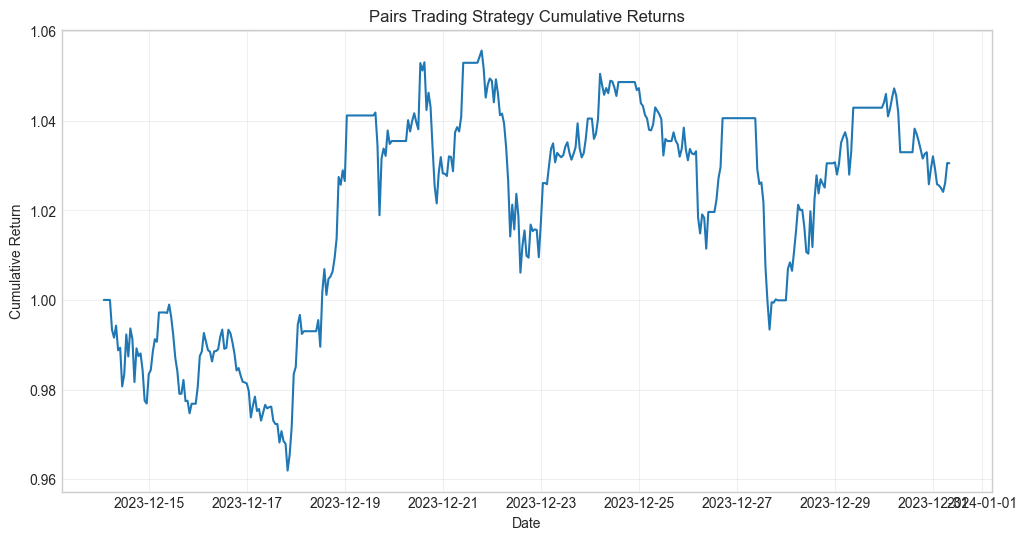

In [26]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(strategy.index, strategy['Cum_Return'])
plt.title('Pairs Trading Strategy Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.savefig('docs/cumulative_returns.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Comparison to Buy and Hold

Compare the pairs trading strategy to simple buy-and-hold approaches.

In [27]:
# Define ticker names for easier reference
ticker_1 = 'BTC'
ticker_2 = 'ETH'

# Rename your test data to match the expected variable names
test_data = pd.DataFrame({
    ticker_1: btc_test,
    ticker_2: eth_test
})

In [28]:
# Calculate buy-and-hold performance
btc_buy_hold = test_data[ticker_1] / test_data[ticker_1].iloc[0]
eth_buy_hold = test_data[ticker_2] / test_data[ticker_2].iloc[0]

# Create comparison dataframe
comparison = pd.DataFrame(index=strategy.index)
comparison['Pairs Strategy'] = strategy['Cum_Return']
comparison['BTC Buy & Hold'] = btc_buy_hold.loc[strategy.index] / btc_buy_hold.loc[strategy.index[0]]
comparison['ETH Buy & Hold'] = eth_buy_hold.loc[strategy.index] / eth_buy_hold.loc[strategy.index[0]]

In [29]:
# Calculate buy-and-hold statistics
btc_return = comparison['BTC Buy & Hold'].iloc[-1] - 1
eth_return = comparison['ETH Buy & Hold'].iloc[-1] - 1
btc_sharpe = np.log(comparison['BTC Buy & Hold'] / comparison['BTC Buy & Hold'].shift(1)).mean() / \
            np.log(comparison['BTC Buy & Hold'] / comparison['BTC Buy & Hold'].shift(1)).std() * np.sqrt(252)
eth_sharpe = np.log(comparison['ETH Buy & Hold'] / comparison['ETH Buy & Hold'].shift(1)).mean() / \
            np.log(comparison['ETH Buy & Hold'] / comparison['ETH Buy & Hold'].shift(1)).std() * np.sqrt(252)

print("\nBuy & Hold Performance:")
print(f"BTC Return: {btc_return:.4f} ({btc_return*100:.2f}%)")
print(f"ETH Return: {eth_return:.4f} ({eth_return*100:.2f}%)")
print(f"BTC Sharpe: {btc_sharpe:.4f}")
print(f"ETH Sharpe: {eth_sharpe:.4f}")


Buy & Hold Performance:
BTC Return: -0.0048 (-0.48%)
ETH Return: 0.0204 (2.04%)
BTC Sharpe: -0.0465
ETH Sharpe: 0.1504


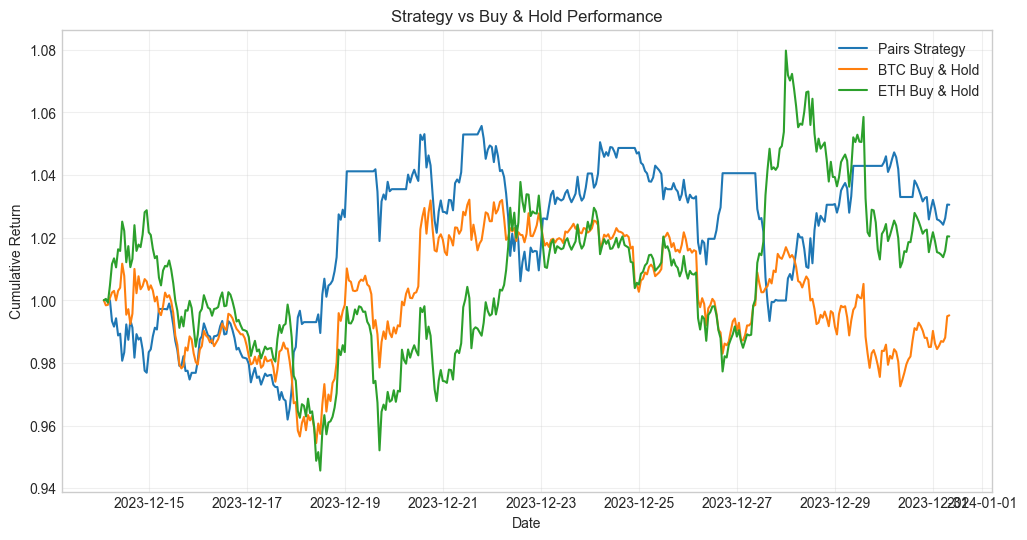

In [30]:
# Plot strategy vs buy and hold
plt.figure(figsize=(12, 6))
plt.plot(comparison.index, comparison['Pairs Strategy'], label='Pairs Strategy')
plt.plot(comparison.index, comparison['BTC Buy & Hold'], label='BTC Buy & Hold')
plt.plot(comparison.index, comparison['ETH Buy & Hold'], label='ETH Buy & Hold')
plt.title('Strategy vs Buy & Hold Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('docs/strategy_vs_buyhold.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Calculate drawdown
cum_returns = strategy['Cum_Return']
running_max = cum_returns.cummax()
drawdown = (cum_returns / running_max) - 1
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")

Maximum Drawdown: -0.0590 (-5.90%)


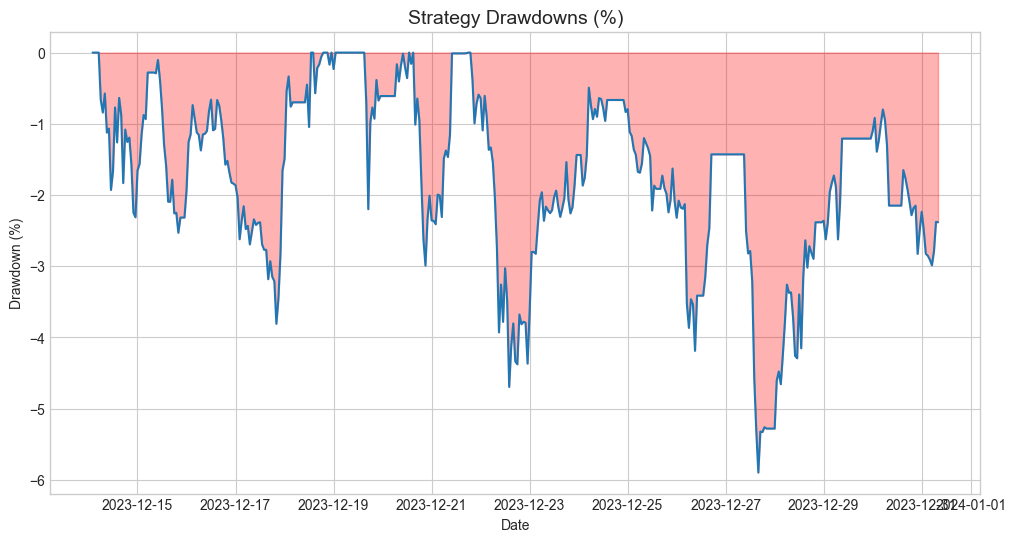

In [32]:
# Plot drawdowns
plt.figure(figsize=(12, 6))
plt.plot(strategy.index, drawdown * 100)
plt.fill_between(strategy.index, drawdown * 100, 0, color='red', alpha=0.3)
plt.title('Strategy Drawdowns (%)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.grid(True)
plt.savefig('docs/drawdowns.png', dpi=300, bbox_inches='tight')
plt.show()

## **12. Market Regime Analysis**

Let's analyze how the correlation between BTC and ETH changes over time, which can impact the performance of our pairs trading strategy.

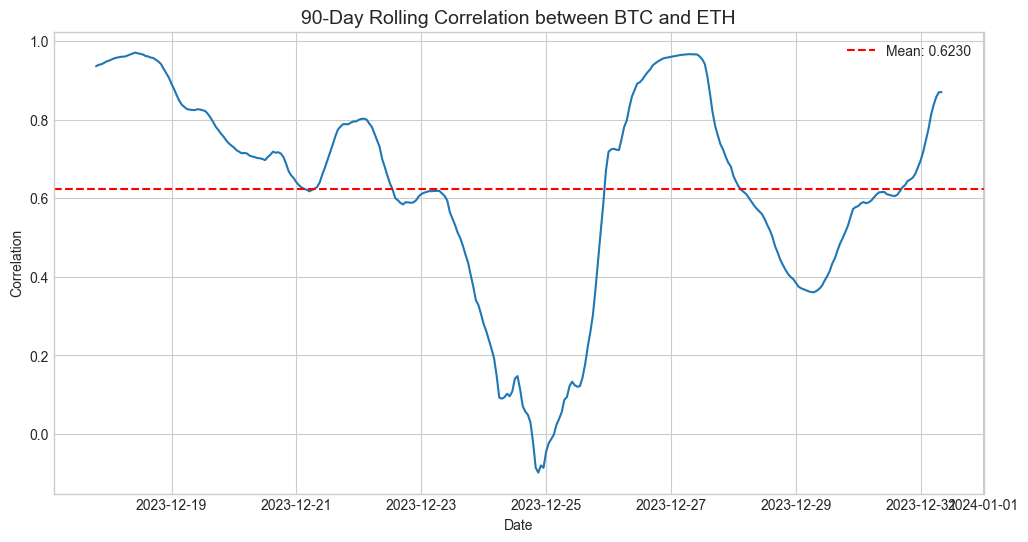

In [33]:
# Calculate 90-day rolling correlation between BTC and ETH
rolling_corr = strategy[ticker_1].rolling(90).corr(strategy[ticker_2])

# Plot rolling correlation
plt.figure(figsize=(12, 6))
plt.plot(rolling_corr.index, rolling_corr)
plt.axhline(rolling_corr.mean(), color='red', linestyle='--', label=f'Mean: {rolling_corr.mean():.4f}')
plt.title('90-Day Rolling Correlation between BTC and ETH', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.savefig('docs/rolling_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# Define strategy_return
strategy_return = total_return

In [35]:
# Create overall comparison statistics
comparison_stats = pd.DataFrame({
    'Metric': ['Total Return', 'Annualized Return', 'Sharpe Ratio', 'Maximum Drawdown'],
    'Pairs Strategy': [
        f"{strategy_return:.2%}", 
        f"{annual_return:.2%}", 
        f"{sharpe_ratio:.4f}", 
        f"{max_drawdown:.2%}"
    ],
    'BTC Buy & Hold': [
        f"{btc_return:.2%}", 
        f"{(1 + btc_return) ** (252 / len(strategy)) - 1:.2%}", 
        f"{btc_sharpe:.4f}", 
        f"{(comparison['BTC Buy & Hold'] / comparison['BTC Buy & Hold'].cummax() - 1).min():.2%}"
    ],
    'ETH Buy & Hold': [
        f"{eth_return:.2%}", 
        f"{(1 + eth_return) ** (252 / len(strategy)) - 1:.2%}", 
        f"{eth_sharpe:.4f}", 
        f"{(comparison['ETH Buy & Hold'] / comparison['ETH Buy & Hold'].cummax() - 1).min():.2%}"
    ]
})

print("\nStrategy Comparison Summary:")
print(comparison_stats)


Strategy Comparison Summary:
              Metric Pairs Strategy BTC Buy & Hold ETH Buy & Hold
0       Total Return          3.05%         -0.48%          2.04%
1  Annualized Return         88.59%         -0.29%          1.23%
2       Sharpe Ratio         1.6577        -0.0465         0.1504
3   Maximum Drawdown         -5.90%         -5.78%         -8.08%


## **13. Summary and Findings**

Let's summarize the key findings from our BTC-ETH pairs trading strategy analysis.

In [36]:
print("Pairs trading strategy between BTC and ETH summary:")
print(f"1. The pair {'is' if pvalue < 0.05 else 'is not'} cointegrated during the training period")
print(f"2. The spread {'is' if adf_result[1] < 0.05 else 'is not'} stationary during the training period")
print(f"3. The strategy generated a {annual_return*100:.2f}% annualized return")
print(f"4. The Sharpe ratio is {sharpe_ratio:.4f}")
print(f"5. The strategy experienced a maximum drawdown of {max_drawdown*100:.2f}%")
print(f"6. The win rate is {win_rate*100:.2f}% ({winning_trades}/{total_trades} trades)")
print(f"7. The average correlation between BTC and ETH is {rolling_corr.mean():.4f}")

Pairs trading strategy between BTC and ETH summary:
1. The pair is not cointegrated during the training period
2. The spread is stationary during the training period
3. The strategy generated a 88.59% annualized return
4. The Sharpe ratio is 1.6577
5. The strategy experienced a maximum drawdown of -5.90%
6. The win rate is 35.14% (13/37 trades)
7. The average correlation between BTC and ETH is 0.6230


In [37]:
# Save strategy data for further analysis
strategy.to_csv('docs/btc_eth_pairs_trading_results.csv')
print("Strategy data saved to 'btc_eth_pairs_trading_results.csv'")

Strategy data saved to 'btc_eth_pairs_trading_results.csv'
